In [1]:
import pandas as pd
import shutil
import os
import numpy as np
import tqdm

import matplotlib.pyplot as plt
import seaborn as sns

from PIL import Image, ImageDraw, ImageFont

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import load_img, img_to_array

from sklearn.metrics import confusion_matrix, classification_report

import pydot
import glob

Loading `RVL_CDIP` dataset from huggingface

In [ ]:
from datasets import load_dataset

dataset = load_dataset('rvl_cdip')

In [ ]:
import shutil

shutil.unpack_archive('dataset/rvl-cdip.tar.gz')

In [2]:
class_names = {
   0 : "letter",
   1 : "form",
   2 : "email",
   # 3 : "handwritten",
   4 : "advertisement",
   5 : "scientific_report",
   6 : "scientific_publication",
   7 : "specification",
   8 : "file_folder",
   9 : "news_article",
   10 : "budget",
   11 : "invoice",
   12 : "presentation",
   13 : "questionnaire",
   14 : "resume",
   15 : "memo"
}

# Selecting classes

In [3]:
import requests, zipfile, io

def download_data():
    url = "https://www.dropbox.com/s/kuw05qmc4uy474d/RVL_CDIP_one_example_per_class.zip?dl=1"
    r = requests.get(url)
    z = zipfile.ZipFile(io.BytesIO(r.content))
    z.extractall()

download_data()

In [4]:
def plot_image(i, img):
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    plt.imshow(img, cmap=plt.cm.binary)
    
    plt.xlabel(class_names[i])

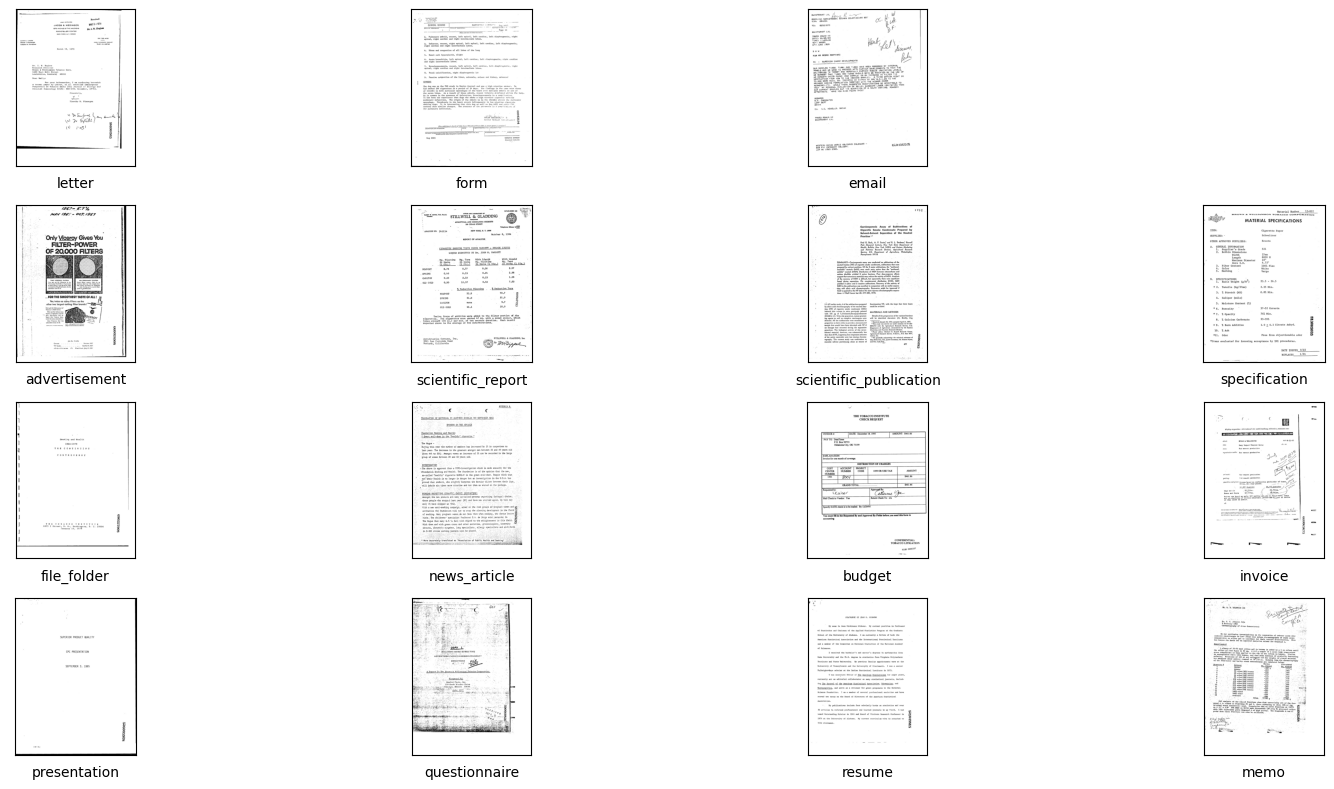

In [5]:
num_rows = 4
num_cols = 4
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))

for i in class_names:
    
    img_path = glob.glob(f'RVL_CDIP_one_example_per_class/{class_names[i]}'+ '/*.tif')
    
    image = Image.open(img_path[0])
    image = image.convert("RGB")

    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, image)
    
    
plt.tight_layout()
plt.show()

Selecting:
- `scientific_publication` - 6
- `budget` - 10
- `invoice` - 11
- `memo` - 15

In [6]:
label_id = [6, 10, 11, 15]

In [7]:
data = pd.read_csv('dataset/train.txt', sep=" ", header=None)
data.columns = ["path", "label"]
df_train = data.loc[data['label'].isin(label_id)]

In [8]:
data = pd.read_csv('dataset/test.txt', sep=" ", header=None)
data.columns = ["path", "label"]
df_test = data.loc[data['label'].isin(label_id)]
df_test = df_test.drop([327])

In [9]:
data = pd.read_csv('dataset/val.txt', sep=" ", header=None)
data.columns = ["path", "label"]
df_val = data.loc[data['label'].isin(label_id)]

Reducing dataset for computing purposes

- train: 2000 samples (~75%)
- test: 600 samples (~23%)
- validation: 100 samples (~2%)

In [10]:
# randomizando imagens

from sklearn.utils import shuffle

df_train = shuffle(df_train, random_state=42)
df_test = shuffle(df_test, random_state=42)
df_val = shuffle(df_val, random_state=42)

df_train.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)

In [11]:
df_train = pd.concat([df_train[df_train['label'] == 6].head(2000),
           df_train[df_train['label'] == 10].head(2000),
           df_train[df_train['label'] == 11].head(2000),
           df_train[df_train['label'] == 15].head(2000)])

In [12]:
df_test = pd.concat([df_test[df_test['label'] == 6].head(600),
           df_test[df_test['label'] == 10].head(600),
           df_test[df_test['label'] == 11].head(600),
           df_test[df_test['label'] == 15].head(600)])

In [13]:
df_val = pd.concat([df_val[df_val['label'] == 6].head(100),
           df_val[df_val['label'] == 10].head(100),
           df_val[df_val['label'] == 11].head(100),
           df_val[df_val['label'] == 15].head(100)])

Creating folders and separating images for each label

In [14]:
%%time

for r in df_train.iterrows():
    image_name = r[1][0]
    label = r[1][1]
    label_ = class_names[label]
    img_name = image_name.split('/')[-1]
    img_name = img_name.split('.')[0]

    image = Image.open(f'images/{image_name}')
    
    dataset_path = os.path.join(
        'datasets/train',
        label_
    )

    os.makedirs(dataset_path, exist_ok=True)
    file_path = os.path.join(dataset_path, img_name)
    jpg_path = file_path + '.jpg'
    image.save(jpg_path)

    del image

CPU times: user 40.7 s, sys: 2.64 s, total: 43.3 s
Wall time: 46.9 s


In [15]:
%%time

for r in df_test.iterrows():
    image_name = r[1][0]
    label = r[1][1]
    label_ = class_names[label]
    img_name = image_name.split('/')[-1]
    img_name = img_name.split('.')[0]

    image = Image.open(f'images/{image_name}')
    
    dataset_path = os.path.join(
        'datasets/test',
        label_
    )

    os.makedirs(dataset_path, exist_ok=True)
    file_path = os.path.join(dataset_path, img_name)
    jpg_path = file_path + '.jpg'
    image.save(jpg_path)

    del image

CPU times: user 12.1 s, sys: 703 ms, total: 12.8 s
Wall time: 13.7 s


In [16]:
%%time

for r in df_val.iterrows():
    image_name = r[1][0]
    label = r[1][1]
    label_ = class_names[label]
    img_name = image_name.split('/')[-1]
    img_name = img_name.split('.')[0]

    image = Image.open(f'images/{image_name}')
    
    dataset_path = os.path.join(
        'datasets/val',
        label_
    )

    os.makedirs(dataset_path, exist_ok=True)
    file_path = os.path.join(dataset_path, img_name)
    jpg_path = file_path + '.jpg'
    image.save(jpg_path)

    del image

CPU times: user 2.04 s, sys: 125 ms, total: 2.16 s
Wall time: 2.33 s


# Preparing dataset

* `train_ds`: training set
* `test_ds`: testing set
* `blind_ds`: validation/blind set

In [17]:
image_height = 600
image_width = 424
image_size = (image_height, image_width)

image_height_region = image_height//3

# batch_size = 32
# batch_size = 16
batch_size = 4

train_ds = tf.keras.utils.image_dataset_from_directory(
    "datasets/train", 
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    "datasets/test",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

blind_ds = tf.keras.utils.image_dataset_from_directory(
    "datasets/val",
    seed=1337,
    image_size=image_size,
    batch_size=batch_size,
)

Found 7950 files belonging to 4 classes.
Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-08-25 23:29:32.588643: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-08-25 23:29:32.588999: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Found 2392 files belonging to 4 classes.
Found 400 files belonging to 4 classes.


In [18]:
class_names = train_ds.class_names
print(class_names)

['budget', 'invoice', 'memo', 'scientific_publication']


In [19]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
blind_ds = blind_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Crop test

Creating layer that crops each file in 3 parts, corresponding to the top, middle and bottom region of the document

In [20]:
for images, labels in train_ds.take(1):
    print(labels)

2023-08-25 23:29:32.858919: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


tf.Tensor([1 1 3 2], shape=(4,), dtype=int32)


2023-08-25 23:29:35.704024: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [21]:
IMG_SHAPE = image_size + (3, )
crop_t = Sequential(
  [
      layers.Cropping2D(cropping=((0, 2*image_height_region), (0, 0)), input_shape=IMG_SHAPE)
  ]
)

crop_m = Sequential(
  [
      layers.Cropping2D(cropping=((image_height_region, image_height_region), (0, 0)), input_shape=IMG_SHAPE)
  ]
)

crop_b = Sequential(
  [
      layers.Cropping2D(cropping=((2*image_height_region, 0), (0, 0)), input_shape=IMG_SHAPE)
  ]
)

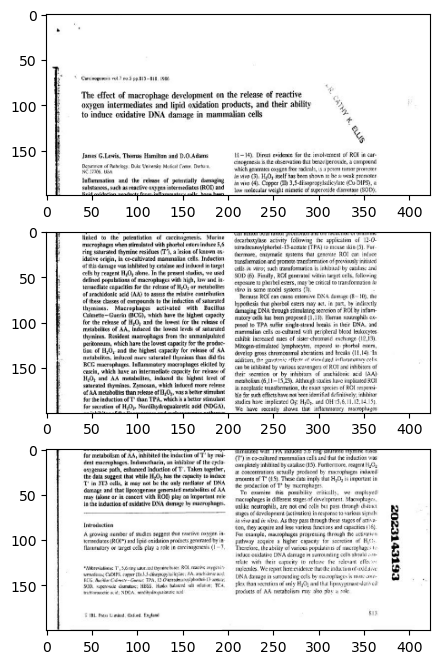

In [24]:
i = 2
plt.figure(figsize=(12, 8))

images_t = crop_t(images, training = True)
images_m = crop_m(images, training = True)
images_b = crop_b(images, training = True)

ax1 = plt.subplot(311)
plt.imshow(images_t[i].numpy().astype("uint8"))

ax2 = plt.subplot(312, sharex=ax1)
plt.imshow(images_m[i].numpy().astype("uint8"))

ax3 = plt.subplot(313, sharex=ax1)
plt.imshow(images_b[i].numpy().astype("uint8"))
plt.show()

# Data Augmentation

In [25]:
augmentation_layer = tf.keras.Sequential([
#     layers.RandomFlip("horizontal_and_vertical"),
    # layers.RandomRotation(1, fill_mode='constant', fill_value=255.0),
    # layers.RandomContrast(0.2),
    layers.RandomZoom(0.3, fill_mode='constant', fill_value=255.0,),
    layers.RandomBrightness(0.2)
])

In [26]:
train_ds = train_ds.shuffle(1000)
train_ds = train_ds.map(lambda x, y: (augmentation_layer(x, training=True), y), num_parallel_calls=AUTOTUNE)
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)

2023-08-25 23:31:20.374611: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2023-08-25 23:31:20.750751: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2023-08-25 23:31:21.046690: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2023-08-25 23:31:21.306105: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2023-08-25 23:31:21.567881: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2023-08-25 23:31:21.833717: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2023-08-25 23:31:22.108770: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2023-08-25 23:31:22.371647: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2023-08-25 23:31:22.660478: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2023-08-25 23:31:22.916958: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2023-08-25 23:31:23.178530: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2023-08-25 23:31:23.447264: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2023-08-25 23:31:23.710959: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-25 23:31:23.965506: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2023-08-25 23:31:24.321839: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2023-08-25 23:31:24.575160: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


2023-08-25 23:31:24.838837: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-25 23:31:25.090299: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


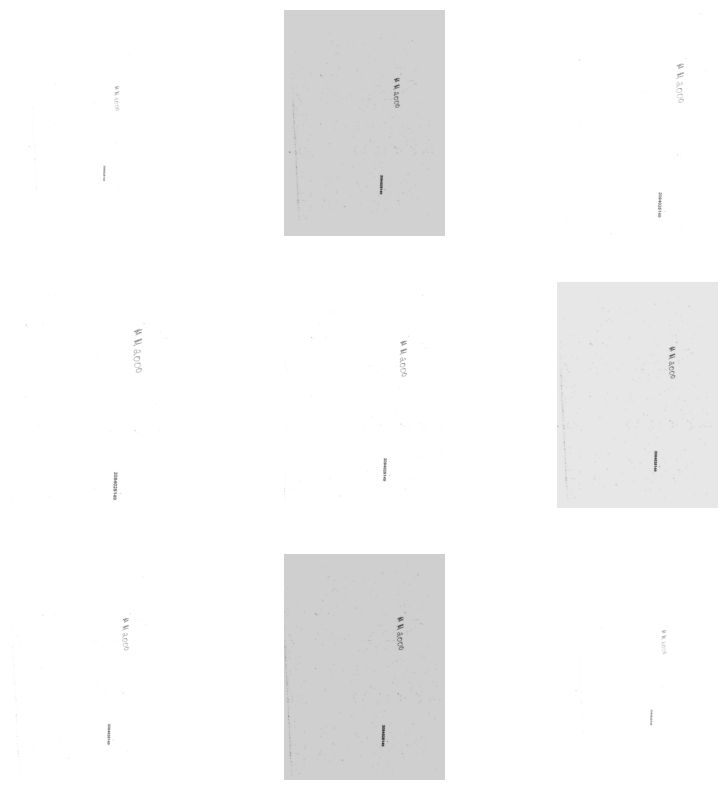

In [27]:
plt.figure(figsize = (10, 10))
for i in range(9):
    augmented_image = augmentation_layer(images,training=True)
    ax = plt.subplot(3,3,i+1)
    plt.imshow(augmented_image[0]/255)
    plt.axis("off")

# Build model

In [28]:
IMG_SHAPE = image_size + (3, )

inputs = keras.Input(shape=(image_height, image_width, 3))
scaling = tf.keras.applications.inception_v3.preprocess_input
x = scaling(inputs)

#### Whole image model

In [29]:
base_model = tf.keras.applications.inception_v3.InceptionV3(weights="imagenet", include_top=False, input_tensor=tf.keras.Input(shape=IMG_SHAPE))
base_model.trainable = False
base_model._name = 'inception_v3_base'
for layer in base_model.layers:
    layer._name = layer._name+"_base"

headModel = base_model(x, training=False)
headModel = layers.GlobalAveragePooling2D()(headModel)
# headModel = layers.Flatten()(headModel)
headModel = layers.Dense(256, activation="relu")(headModel)
headModel = layers.Dropout(0.4)(headModel)
headModel=keras.Model(inputs=inputs, outputs=headModel)

In [30]:
headModel.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 600, 424, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 600, 424, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 600, 424, 3)      0         
 a)                                                              
                                                                 
 inception_v3_base (Function  (None, 17, 11, 2048)     21802784  
 al)                                                             
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                      

#### Top region model

In [31]:
top_model = tf.keras.applications.inception_v3.InceptionV3(weights=None, include_top=False, input_tensor=tf.keras.Input(shape=(image_height_region,image_width, 3)))
top_model.trainable = False
top_model._name = 'inception_v3_top'
for layer in top_model.layers:
    layer._name = layer._name+"_top"
    
cropped_t = layers.Cropping2D(cropping=((0, 2*image_height_region), (0, 0)), input_shape=IMG_SHAPE)
x_t = cropped_t(inputs)

topModel = top_model(x_t, training=False)

# topModel = top_model.output

topModel = layers.GlobalAveragePooling2D()(topModel)
# topModel = layers.Flatten()(topModel)
topModel = layers.Dense(256, activation="relu")(topModel)
topModel = layers.Dropout(0.4)(topModel)
topModel = tf.keras.Model(inputs=inputs, outputs=topModel)

In [32]:
topModel.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 600, 424, 3)]     0         
                                                                 
 cropping2d_3 (Cropping2D)   (None, 200, 424, 3)       0         
                                                                 
 inception_v3_top (Functiona  (None, 4, 11, 2048)      21802784  
 l)                                                              
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_1 (Dense)             (None, 256)               524544    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0   

#### Middle region model

In [33]:
middle_model = tf.keras.applications.inception_v3.InceptionV3(weights=None, include_top=False, input_tensor=tf.keras.Input(shape=(image_height_region,image_width, 3)))
middle_model.trainable = False
middle_model._name = 'inception_v3_middle'
for layer in middle_model.layers:
    layer._name = layer._name+"_middle"

cropped_m = layers.Cropping2D(cropping=((image_height_region, image_height_region), (0, 0)), input_shape=IMG_SHAPE)
x_m = cropped_m(inputs)

# middleModel = middle_model.output

middleModel = middle_model(x_m, training=False)
middleModel = layers.GlobalAveragePooling2D()(middleModel)
# middleModel = layers.Flatten()(middleModel)
middleModel = layers.Dense(256, activation="relu")(middleModel)
middleModel = layers.Dropout(0.4)(middleModel)
middleModel = tf.keras.Model(inputs=inputs, outputs=middleModel)

In [34]:
middleModel.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 600, 424, 3)]     0         
                                                                 
 cropping2d_4 (Cropping2D)   (None, 200, 424, 3)       0         
                                                                 
 inception_v3_middle (Functi  (None, 4, 11, 2048)      21802784  
 onal)                                                           
                                                                 
 global_average_pooling2d_2   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_2 (Dense)             (None, 256)               524544    
                                                                 
 dropout_2 (Dropout)         (None, 256)               0   

#### Bottom region model

In [35]:
bottom_model = tf.keras.applications.inception_v3.InceptionV3(weights=None, include_top=False, input_tensor=tf.keras.Input(shape=(image_height_region,image_width, 3)))
bottom_model.trainable = False
bottom_model._name = 'inception_v3_bottom'
for layer in bottom_model.layers:
    layer._name = layer._name+"_bottom"

cropped_b = layers.Cropping2D(cropping=((2*image_height_region, 0), (0, 0)), input_shape=IMG_SHAPE)
x_b = cropped_b(x)

bottomModel = bottom_model(x_b, training=False)
bottomModel = layers.GlobalAveragePooling2D()(bottomModel)
# bottomModel = layers.Flatten()(bottomModel)
bottomModel = layers.Dense(256, activation="relu")(bottomModel)
bottomModel = layers.Dropout(0.4)(bottomModel)
bottomModel = tf.keras.Model(inputs=inputs, outputs=bottomModel)

In [36]:
bottomModel.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 600, 424, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 600, 424, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 600, 424, 3)      0         
 a)                                                              
                                                                 
 cropping2d_5 (Cropping2D)   (None, 200, 424, 3)       0         
                                                                 
 inception_v3_bottom (Functi  (None, 4, 11, 2048)      21802784  
 onal)                                                           
                                                           

#### Concatenate models

In [37]:
merged = layers.Concatenate()([headModel.output, topModel.output, middleModel.output, bottomModel.output])
merged = layers.Dense(256, activation = 'relu')(merged)
merged = layers.Dropout(0.4)(merged)
output = layers.Dense(len(class_names), activation='sigmoid', name = "class")(merged)

### Final model

In [38]:
model = tf.keras.Model(inputs=inputs, outputs=output)

In [39]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])

In [40]:
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 600, 424, 3  0           []                               
                                )]                                                                
                                                                                                  
 tf.math.truediv (TFOpLambda)   (None, 600, 424, 3)  0           ['input_1[0][0]']                
                                                                                                  
 tf.math.subtract (TFOpLambda)  (None, 600, 424, 3)  0           ['tf.math.truediv[0][0]']        
                                                                                                  
 cropping2d_3 (Cropping2D)      (None, 200, 424, 3)  0           ['input_1[0][0]']          

In [41]:
# tf.keras.utils.plot_model(model)

<img src="output.png">

In [42]:
%%time

epochs=10

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

2023-08-25 23:31:37.639179: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-25 23:31:37.822746: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 1/10


2023-08-25 23:31:42.639362: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1988/1988 [==============================] - ETA: 0s - loss: 1.0947 - accuracy: 0.5667

2023-08-25 23:36:37.190134: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1988/1988 [==============================] - 386s 186ms/step - loss: 1.0947 - accuracy: 0.5667 - val_loss: 0.9966 - val_accuracy: 0.5924
Epoch 2/10


2023-08-25 23:38:03.885098: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1988/1988 [==============================] - 367s 184ms/step - loss: 0.8116 - accuracy: 0.6829 - val_loss: 0.8690 - val_accuracy: 0.6421
Epoch 3/10


2023-08-25 23:44:10.833101: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1988/1988 [==============================] - 366s 184ms/step - loss: 0.7314 - accuracy: 0.7128 - val_loss: 0.8193 - val_accuracy: 0.6401
Epoch 4/10


2023-08-25 23:50:17.186312: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1988/1988 [==============================] - 367s 185ms/step - loss: 0.6904 - accuracy: 0.7322 - val_loss: 0.7672 - val_accuracy: 0.7053
Epoch 5/10


2023-08-25 23:56:24.351500: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


1988/1988 [==============================] - 365s 184ms/step - loss: 0.6577 - accuracy: 0.7403 - val_loss: 0.7457 - val_accuracy: 0.7228


2023-08-26 00:02:29.966410: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 6/10
1988/1988 [==============================] - 367s 184ms/step - loss: 0.6387 - accuracy: 0.7458 - val_loss: 0.7323 - val_accuracy: 0.6990


2023-08-26 00:08:36.780717: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 7/10
1988/1988 [==============================] - 367s 185ms/step - loss: 0.6184 - accuracy: 0.7561 - val_loss: 0.7058 - val_accuracy: 0.7203


2023-08-26 00:14:44.203890: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 8/10
1988/1988 [==============================] - 369s 185ms/step - loss: 0.6064 - accuracy: 0.7655 - val_loss: 0.7309 - val_accuracy: 0.6869


2023-08-26 00:20:53.054831: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 9/10
1988/1988 [==============================] - 367s 184ms/step - loss: 0.5909 - accuracy: 0.7732 - val_loss: 0.6759 - val_accuracy: 0.7358


2023-08-26 00:27:00.202918: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 10/10
1988/1988 [==============================] - 365s 184ms/step - loss: 0.5825 - accuracy: 0.7762 - val_loss: 0.7038 - val_accuracy: 0.7048
CPU times: user 1h 3min 54s, sys: 19min 26s, total: 1h 23min 21s
Wall time: 1h 1min 28s


## Model results before finetuning

#### Test data

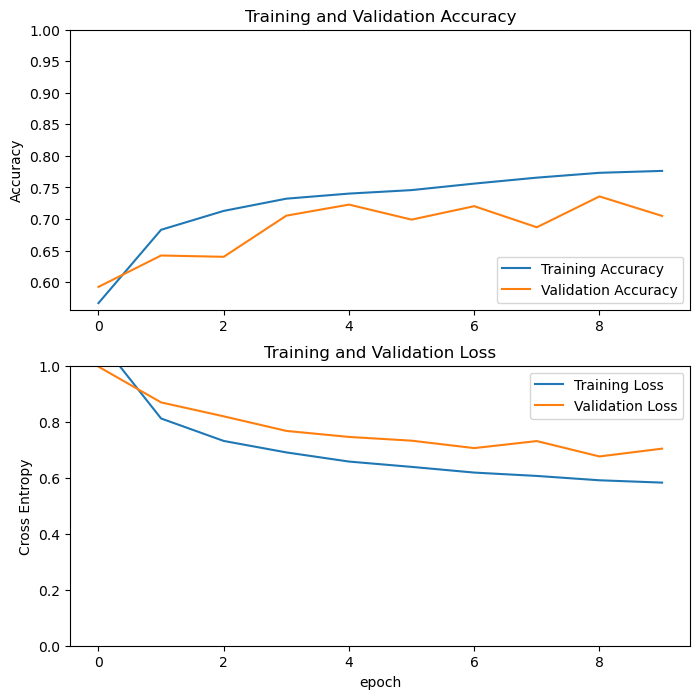

In [43]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [44]:
labels = list(map(lambda x: x[1], val_ds))
y_test = tf.concat(labels, axis = 0)

y_pred = model.predict(val_ds)
y_pred = np.argmax(y_pred, axis=1)

conf_mat = confusion_matrix(y_test, y_pred)

2023-08-26 00:33:14.594987: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


598/598 [==============================] - 88s 136ms/step


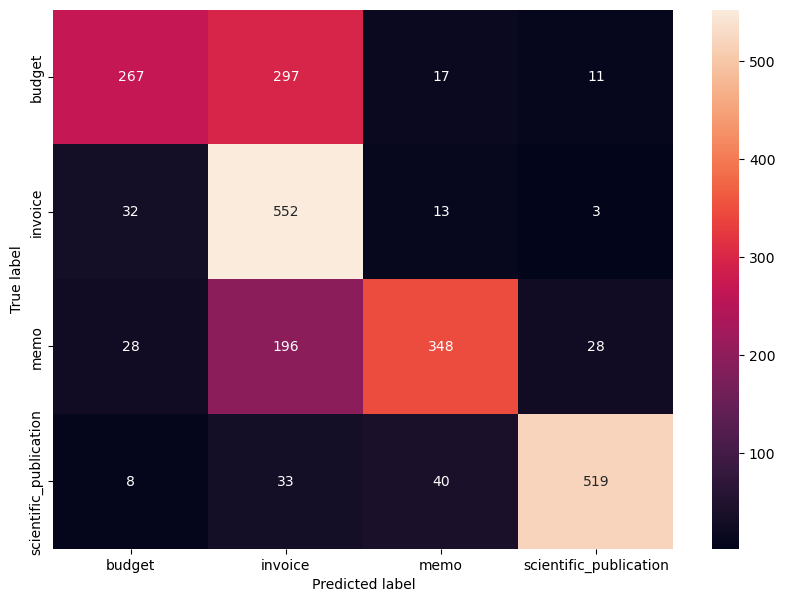

In [45]:
df_cm = pd.DataFrame(conf_mat, index=class_names, columns=class_names)
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [46]:
print(classification_report(y_test, y_pred, target_names=class_names))

                        precision    recall  f1-score   support

                budget       0.80      0.45      0.58       592
               invoice       0.51      0.92      0.66       600
                  memo       0.83      0.58      0.68       600
scientific_publication       0.93      0.86      0.89       600

              accuracy                           0.70      2392
             macro avg       0.77      0.70      0.70      2392
          weighted avg       0.77      0.70      0.70      2392



#### Validation data

In [47]:
labels_blind = list(map(lambda x: x[1], blind_ds))
y_blind = tf.concat(labels_blind, axis = 0)

y_pred_blind = model.predict(blind_ds)
y_pred_blind = np.argmax(y_pred_blind, axis=1)

conf_mat_blind = confusion_matrix(y_blind, y_pred_blind)

100/100 [==============================] - 14s 133ms/step


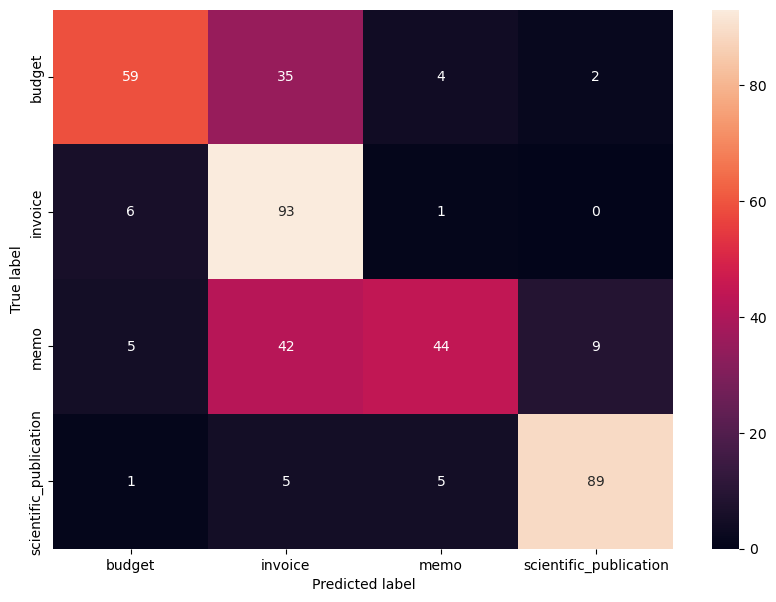

In [48]:
df_cm_blind = pd.DataFrame(conf_mat_blind, index=class_names, columns=class_names)
plt.figure(figsize = (10,7))
sns.heatmap(df_cm_blind, annot=True, fmt='g')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [49]:
print(classification_report(y_blind, y_pred_blind, target_names=class_names))

                        precision    recall  f1-score   support

                budget       0.83      0.59      0.69       100
               invoice       0.53      0.93      0.68       100
                  memo       0.81      0.44      0.57       100
scientific_publication       0.89      0.89      0.89       100

              accuracy                           0.71       400
             macro avg       0.77      0.71      0.71       400
          weighted avg       0.77      0.71      0.71       400



## Fine tuning

In [50]:
base_model.trainable = True
top_model.trainable = True
middle_model.trainable = True
bottom_model.trainable = True

In [51]:
%%time

epochs = 3
history =  model.fit(train_ds, epochs=epochs, validation_data=val_ds)

2023-08-26 00:35:32.673128: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2023-08-26 00:35:32.865906: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


Epoch 1/3


: 

: 

## Results after finetuning

#### Test data

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
labels = list(map(lambda x: x[1], val_ds))
y_test = tf.concat(labels, axis = 0)

y_pred = model.predict(val_ds)
y_pred = np.argmax(y_pred, axis=1)

conf_mat = confusion_matrix(y_test, y_pred)

In [ ]:
df_cm = pd.DataFrame(conf_mat, index=class_names, columns=class_names)
plt.figure(figsize = (10,7))
sns.heatmap(df_cm, annot=True, fmt='g')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
print(classification_report(y_test, y_pred, target_names=class_names))

#### Validation data

In [ ]:
labels_blind = list(map(lambda x: x[1], blind_ds))
y_blind = tf.concat(labels_blind, axis = 0)

y_pred_blind = model.predict(blind_ds)
y_pred_blind = np.argmax(y_pred_blind, axis=1)

conf_mat_blind = confusion_matrix(y_blind, y_pred_blind)

In [ ]:
df_cm_blind = pd.DataFrame(conf_mat_blind, index=class_names, columns=class_names)
plt.figure(figsize = (10,7))
sns.heatmap(df_cm_blind, annot=True, fmt='g')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [ ]:
print(classification_report(y_blind, y_pred_blind, target_names=class_names))

#### Validation with random images

In [ ]:
import glob
import random

random_images = glob.glob('datasets/random'+ '/*.jpg')
random.shuffle(random_images)
len(random_images)

In [ ]:
def plot_image(i, predictions_array, img):
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    
    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    color = 'blue'
    
    plt.xlabel("{} {:2.0f}%".format(class_names[predicted_label],
                                100*np.max(predictions_array)),
                                color=color)

In [ ]:
num_rows = 4
num_cols = 4
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    
    img_path = random_images[i]
    
    img = tf.keras.utils.load_img(img_path, target_size=(image_height, image_width))
    img_array = tf.keras.utils.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    predictions = model(img_array)
    
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, predictions, img)
    
plt.tight_layout()
plt.show()

## Save model

In [ ]:
tf.saved_model.save(model, 'model/inceptionV3-document_classification_concat')